In [15]:
import pandas as pd
import numpy as np
PATH = "OpenMATB/sessions/2024-03-24/Session 31"

sesion_path = 'OpenMATB/sessions/2024-03-24/Session 31/31_240324_133453.csv'
data = pd.read_csv(sesion_path)
read_data = data[data.apply(lambda row: row.astype(str).str.contains('performance', case=False).any(), axis=1)]
output_file_path = sesion_path.replace('.csv', '_performance.csv')
read_data.to_csv(output_file_path, index=False)
print(read_data.head(10))


          logtime  scenario_time         type  module           address value
192  12315.194857       0.241782  performance  resman    a_in_tolerance     1
193  12315.194897       0.241782  performance  resman       a_deviation     0
194  12315.194919       0.241782  performance  resman    b_in_tolerance     1
195  12315.194937       0.241782  performance  resman       b_deviation     0
206  12315.200187       0.241782  performance   track        joystick_x     0
207  12315.200202       0.241782  performance   track        joystick_y     0
230  12315.204369       0.251150  performance   track        joystick_x     0
231  12315.204384       0.251150  performance   track        joystick_y     0
232  12315.204412       0.251150  performance   track  cursor_in_target     1
233  12315.204433       0.251150  performance   track  center_deviation   0.0


In [16]:
import os
from glob import glob
import pandas as pd

EXT = "*.csv"
PATH = "OpenMATB/sessions/2024-03-24/Session 31"

all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]

dfs = []
for file in all_csv_files:#nije idempotentno
    if "performance" in file:
        df = pd.read_csv(file)
        dfs.append(df)


performance_data = pd.concat(dfs, join='outer', ignore_index=True)

print(performance_data)


            logtime  scenario_time         type  module           address  \
0      12315.194857       0.241782  performance  resman    a_in_tolerance   
1      12315.194897       0.241782  performance  resman       a_deviation   
2      12315.194919       0.241782  performance  resman    b_in_tolerance   
3      12315.194937       0.241782  performance  resman       b_deviation   
4      12315.200187       0.241782  performance   track        joystick_x   
...             ...            ...          ...     ...               ...   
18580  12554.909915     239.956357  performance   track  center_deviation   
18581  12554.943991     239.990491  performance   track  cursor_in_target   
18582  12554.944113     239.990491  performance   track  center_deviation   
18583  12554.976902     240.023308  performance   track  cursor_in_target   
18584  12554.977005     240.023308  performance   track  center_deviation   

          value  
0             1  
1             0  
2             1  
3  

## Track - sekcija

In [21]:
import sklearn
from sklearn.model_selection import train_test_split
track_data = performance_data[
    performance_data.apply(
        lambda row: row.astype(str).str.contains('track', case=False).any() and 
                    row.astype(str).str.contains('center_deviation', case=False).any(),
        axis=1
    )
]

track_data['value'] = pd.to_numeric(track_data['value'], errors='coerce')



numeric_columns = track_data.select_dtypes(include='number').columns.tolist()
track_data_encoded = track_data[numeric_columns].drop(['logtime'], axis=1)  
window_size = 30 * 30  
track_data_encoded['rolling_avg'] = track_data_encoded['value'].rolling(window=window_size, min_periods=1).mean()
#track_data_encoded['std_dev'] = track_data_encoded['value'].rolling(window=window_size, min_periods=0).std()
#track_data_encoded['std_dev'] = track_data_encoded['std_dev'].fillna(0)
#track_data_encoded['min_dev'] = track_data_encoded['value'].rolling(window=window_size, min_periods=1).min()
#track_data_encoded['max_dev'] = track_data_encoded['value'].rolling(window=window_size, min_periods=1).max()

print(track_data_encoded)
output_file_path = sesion_path.replace('.csv', '_performance_track.csv')
track_data_encoded.to_csv(output_file_path, index=False)


       scenario_time     value  rolling_avg
9           0.251150  0.000000     0.000000
13          0.298713  2.429249     1.214624
15          0.323102  3.643778     2.024342
17          0.353506  3.452159     2.381296
19          0.390585  3.265686     2.558174
...              ...       ...          ...
18576     239.890237  0.717224    49.414460
18578     239.923449  1.347125    49.414500
18580     239.956357  1.287202    49.414613
18582     239.990491  0.618979    49.414083
18584     240.023308  1.072736    49.413011

[7209 rows x 3 columns]


/tmp/ipykernel_4203/3601244921.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_data['value'] = pd.to_numeric(track_data['value'], errors='coerce')


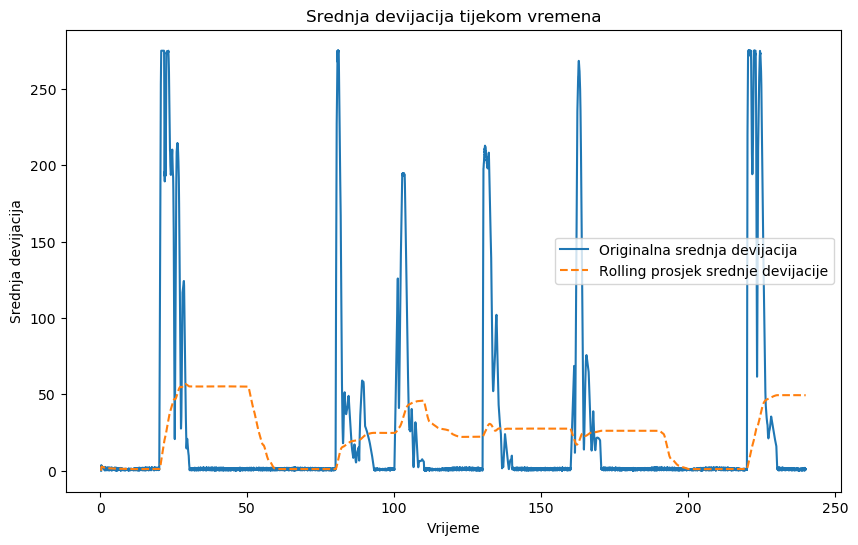

In [22]:
import matplotlib.pyplot as plt

scenario_time = track_data_encoded['scenario_time'].values
center_deviation = track_data_encoded['value'].values
rolling_avg = track_data_encoded['rolling_avg'].values

plt.figure(figsize=(10, 6))
plt.plot(scenario_time, center_deviation, label='Originalna srednja devijacija')
plt.plot(scenario_time, rolling_avg, label='Rolling prosjek srednje devijacije', linestyle='--')
plt.xlabel('Vrijeme')
plt.ylabel('Srednja devijacija')
plt.title('Srednja devijacija tijekom vremena')
plt.legend()
plt.show()

In [23]:
y_track = track_data_encoded['value'].values
X_track = track_data_encoded[['rolling_avg', 'value']]
X_train, X_test, y_train, y_test = train_test_split(X_track, y_track, test_size=0.2, shuffle=False)

In [24]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
import numpy as np

time_steps = 256
X_train_sequence = []
y_train_sequence = []

for i in range(len(X_train) - time_steps):
    X_train_sequence.append(X_train.iloc[i:i + time_steps].values)
    y_train_sequence.append(y_train[i + time_steps])

X_train_sequence = np.array(X_train_sequence)
y_train_sequence = np.array(y_train_sequence)
y_train_sequence = np.asarray(y_train_sequence).astype(np.float32)

model = Sequential()
model.add(GRU(units=256, return_sequences=True, input_shape=(X_train_sequence.shape[1], X_train_sequence.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.fit(X_train_sequence, y_train_sequence, epochs=15, batch_size=64)




Epoch 1/15
87/87 [==============================] - 125s 1s/step - loss: 2696.1396
Epoch 2/15
87/87 [==============================] - 118s 1s/step - loss: 1317.2302
Epoch 3/15
87/87 [==============================] - 119s 1s/step - loss: 646.7281
Epoch 4/15
87/87 [==============================] - 120s 1s/step - loss: 324.3664
Epoch 5/15
87/87 [==============================] - 122s 1s/step - loss: 172.6938
Epoch 6/15
87/87 [==============================] - 121s 1s/step - loss: 104.7321
Epoch 7/15
87/87 [==============================] - 121s 1s/step - loss: 69.7231
Epoch 8/15
87/87 [==============================] - 120s 1s/step - loss: 47.8364
Epoch 9/15
87/87 [==============================] - 130s 2s/step - loss: 39.1237
Epoch 10/15
87/87 [==============================] - 164s 2s/step - loss: 30.9114
Epoch 11/15
87/87 [==============================] - 175s 2s/step - loss: 26.1352
Epoch 12/15
87/87 [==============================] - 186s 2s/step - loss: 22.5601
Epoch 13/15
87/87

In [63]:
from sklearn.metrics import mean_absolute_error
X_test_sequence = []
y_test_sequence = []
for i in range(len(X_test) - time_steps):
    X_test_sequence.append(X_test.iloc[i:i+time_steps].values)
    y_test_sequence.append(y_test[i+time_steps])

X_test_sequence = np.array(X_test_sequence)
y_test_sequence = np.array(y_test_sequence)
X_test_sequence = np.reshape(X_test_sequence, (X_test_sequence.shape[0], X_test_sequence.shape[1], X_test_sequence.shape[2]))

y_pred = model.predict(X_test_sequence)
mae = mean_absolute_error(y_test_sequence, y_pred)
print("Mean Absolute Error (MAE) on test set:", mae)

ValueError: in user code:

    File "/home/nelly/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/nelly/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nelly/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/nelly/.local/lib/python3.8/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/nelly/.local/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/nelly/.local/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 256, 5), found shape=(None, 64, 5)


## Resman - sekcija

In [95]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

In [96]:
resman_data = performance_data[
    performance_data.apply(
        lambda row: row.astype(str).str.contains('resman', case=False).any() and 
                    row.astype(str).str.contains('a_deviation', case=False).any() or row.astype(str).str.contains('b_deviation', case=False).any(),
        axis=1
    )
]

resman_data['value'] = pd.to_numeric(resman_data['value'], errors='coerce')
resman_data = handle_non_numerical_data(resman_data)
numeric_columns = resman_data.select_dtypes(include='number').columns.tolist()
resman_data_encoded = resman_data[numeric_columns].drop(['scenario_time','logtime','type','module'], axis=1)
window_size = 5 

data_address_1 = resman_data_encoded[resman_data_encoded['address'] == 1]
data_address_0 = resman_data_encoded[resman_data_encoded['address'] == 0]

data_address_0['rolling_avg'] = data_address_0['value'].rolling(window=window_size, min_periods=1).mean()
data_address_1['rolling_avg'] = data_address_1['value'].rolling(window=window_size, min_periods=1).mean()

print(data_address_0[['value', 'rolling_avg']])
print(data_address_1[['value', 'rolling_avg']])
output_file_path = sesion_path.replace('.csv', '_performance_resman.csv')
resman_data_encoded.to_csv(output_file_path, index=False)

       value  rolling_avg
1          0          0.0
131      -26        -13.0
257      -52        -26.0
381      -78        -39.0
505     -104        -52.0
...      ...          ...
18053    258        218.0
18177    278        238.0
18301    272        252.8
18428    266        262.4
18554    260        266.8

[120 rows x 2 columns]
       value  rolling_avg
3          0          0.0
133      -26        -13.0
259      -52        -26.0
383      -78        -39.0
507     -104        -52.0
...      ...          ...
18055   -276       -316.0
18179   -256       -296.0
18304   -236       -276.0
18430   -216       -256.0
18556   -196       -236.0

[120 rows x 2 columns]


/tmp/ipykernel_9363/584443957.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resman_data['value'] = pd.to_numeric(resman_data['value'], errors='coerce')
/tmp/ipykernel_9363/33590573.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = list(map(convert_to_int, df[column]))
/tmp/ipykernel_9363/584443957.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

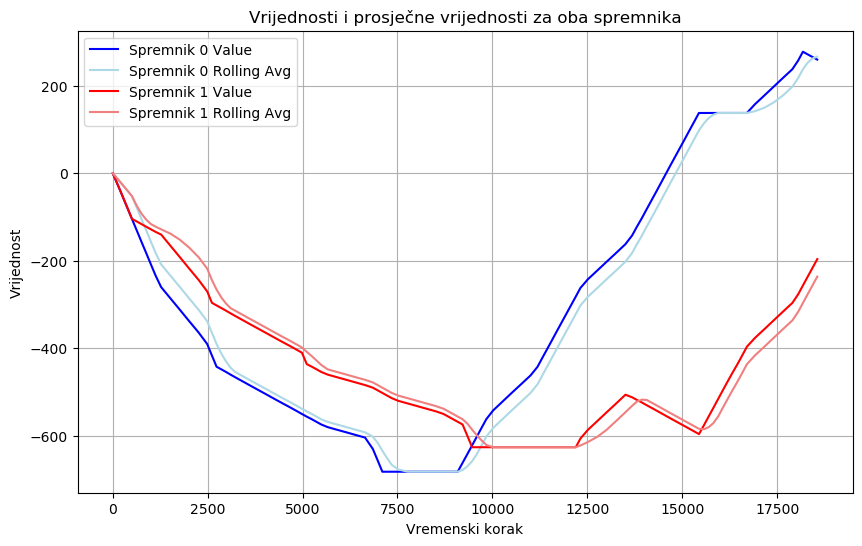

In [97]:
import matplotlib.pyplot as plt

value_0 = data_address_0['value']
rolling_avg_0 = data_address_0['rolling_avg']

value_1 = data_address_1['value']
rolling_avg_1 = data_address_1['rolling_avg']

plt.figure(figsize=(10, 6))

plt.plot(value_0, label='Spremnik 0 Value', color='blue')
plt.plot(rolling_avg_0, label='Spremnik 0 Rolling Avg', color='lightblue')
plt.plot(value_1, label='Spremnik 1 Value', color='red')
plt.plot(rolling_avg_1, label='Spremnik 1 Rolling Avg', color='lightcoral')

plt.xlabel('Vremenski korak')
plt.ylabel('Vrijednost')
plt.title('Vrijednosti i prosječne vrijednosti za oba spremnika')
plt.legend()
plt.grid(True)

plt.show()



In [98]:
y1_resman = resman_data_encoded['value'].values
X1_resman = resman_data_encoded
X1_train_resman, X1_test_resman, y1_train_resman, y1_test_resman = train_test_split(X1_resman, y1_resman, test_size=0.3, shuffle=False)
y2_resman = resman_data_encoded['value'].values
X2_resman = resman_data_encoded
X2_train_resman, X2_test_resman, y2_train_resman, y2_test_resman = train_test_split(X2_resman, y2_resman, test_size=0.3, shuffle=False)

In [102]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
import numpy as np

time_steps = 64
X1_train_sequence_resman = []
y1_train_sequence_resman = []

for i in range(len(X1_train_resman) - time_steps):
    X1_train_sequence_resman.append(X1_train_resman.iloc[i:i + time_steps].values)
    y1_train_sequence_resman.append(y1_train_resman[i + time_steps])

X1_train_sequence_resman = np.array(X1_train_sequence_resman)
y1_train_sequence_resman = np.array(y1_train_sequence_resman)
y1_train_sequence_resman = np.asarray(y1_train_sequence_resman).astype(np.float32)

X2_train_sequence_resman = []
y2_train_sequence_resman = []

for i in range(len(X2_train_resman) - time_steps):
    X2_train_sequence_resman.append(X2_train_resman.iloc[i:i + time_steps].values)
    y2_train_sequence_resman.append(y2_train_resman[i + time_steps])

X2_train_sequence_resman = np.array(X2_train_sequence_resman)
y2_train_sequence_resman = np.array(y2_train_sequence_resman)
y2_train_sequence_resman = np.asarray(y2_train_sequence_resman).astype(np.float32)


model1 = Sequential([
    GRU(64, input_shape=(X1_train_sequence_resman.shape[1], X1_train_sequence_resman.shape[2]), return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(1)
])

model1.compile(optimizer='adam', loss='mean_squared_error')
model1.fit(X1_train_sequence_resman, y1_train_sequence_resman, epochs=300, batch_size=32, validation_split=0.1)

model2 = Sequential([
    GRU(64, input_shape=(X2_train_sequence_resman.shape[1], X2_train_sequence_resman.shape[2]), return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mean_squared_error')
model2.fit(X2_train_sequence_resman, y2_train_sequence_resman, epochs=300, batch_size=32, validation_split=0.1)


Epoch 1/300
3/3 [==============================] - 5s 488ms/step - loss: 312746.2500 - val_loss: 203196.1875
Epoch 2/300
3/3 [==============================] - 0s 104ms/step - loss: 311598.6250 - val_loss: 202292.6875
Epoch 3/300
3/3 [==============================] - 0s 100ms/step - loss: 310339.5312 - val_loss: 201491.6094
Epoch 4/300
3/3 [==============================] - 0s 103ms/step - loss: 309348.6562 - val_loss: 200804.7656
Epoch 5/300
3/3 [==============================] - 0s 102ms/step - loss: 308457.6875 - val_loss: 200163.9531
Epoch 6/300
3/3 [==============================] - 0s 100ms/step - loss: 307614.3750 - val_loss: 199562.9062
Epoch 7/300
3/3 [==============================] - 0s 101ms/step - loss: 306852.7188 - val_loss: 199071.0000
Epoch 8/300
3/3 [==============================] - 0s 103ms/step - loss: 306220.1562 - val_loss: 198635.5938
Epoch 9/300
3/3 [==============================] - 0s 99ms/step - loss: 305657.4688 - val_loss: 198235.7656
Epoch 10/300
3/3 [==

In [4]:
X1_test_sequence_resman = []
y1_test_sequence_resman = []

for i in range(len(X1_test_resman) - time_steps):
    X1_test_sequence_resman.append(X1_test_resman.iloc[i:i+time_steps].values)
    y1_test_sequence_resman.append(y1_test_resman[i+time_steps])
print("Original shape:", X1_test_sequence_resman.shape)

X1_test_sequence_resman = np.array(X1_test_sequence_resman)
y1_test_sequence_resman = np.array(y1_test_sequence_resman)
X1_test_sequence_resman = np.reshape(X1_test_sequence_resman, (X1_test_sequence_resman.shape[0], X1_test_sequence_resman.shape[1], X1_test_sequence_resman.shape[2]))

y1_pred_resman = model1.predict(X1_test_sequence_resman)
mae_resman = mean_absolute_error(y1_test_sequence_resman, y1_pred_resman)
print("Mean Absolute Error (MAE) on test set:", mae_resman)

X2_test_sequence_resman = []
y2_test_sequence_resman = []
for i in range(len(X2_test_resman) - time_steps):
    X2_test_sequence_resman.append(X2_test_resman.iloc[i:i+time_steps].values)
    y2_test_sequence_resman.append(y2_test_resman[i+time_steps])

X2_test_sequence_resman = np.array(X2_test_sequence_resman)
y2_test_sequence_resman = np.array(y2_test_sequence_resman)
X2_test_sequence_resman = np.reshape(X2_test_sequence_resman, (X2_test_sequence_resman.shape[0], X2_test_sequence_resman.shape[1], X2_test_sequence_resman.shape[2]))

y2_pred_resman = model2.predict(X2_test_sequence_resman)
mae_resman = mean_absolute_error(y2_test_sequence_resman, y2_pred_resman)
print("Mean Absolute Error (MAE) on test set:", mae_resman)

NameError: name 'X1_test_resman' is not defined

## Sysmon - sekcija

In [85]:
sysmon_data = performance_data[
    performance_data.apply(
        lambda row: row.astype(str).str.contains('sysmon', case=False).any() and
                    (row.astype(str).str.contains('signal_detection', case=False).any() or
                     row.astype(str).str.contains('response_time', case=False).any()),
        axis=1
    )
]
sysmon_data_encoded = pd.get_dummies(sysmon_data, columns=['address'])
print(sysmon_data_encoded)
output_file_path = sesion_path.replace('.csv', '_performance_sysmon.csv')
sysmon_data_encoded.to_csv(output_file_path, index=False)

            logtime  scenario_time         type  module value  \
1295   12335.426107      20.471866  performance  sysmon  MISS   
1296   12335.426143      20.471866  performance  sysmon   NaN   
4365   12375.656604      60.702440  performance  sysmon  MISS   
4366   12375.656638      60.702440  performance  sysmon   NaN   
4486   12377.572484      62.602710  performance  sysmon    FA   
4487   12377.572527      62.602710  performance  sysmon   NaN   
4521   12378.126483      63.151276  performance  sysmon    FA   
4522   12378.126538      63.151276  performance  sysmon   NaN   
8779   12426.918251     111.948531  performance  sysmon   HIT   
8780   12426.918295     111.948531  performance  sysmon  1800   
12455  12475.632915     160.678655  performance  sysmon  MISS   
12456  12475.632949     160.678655  performance  sysmon   NaN   
12672  12477.382256     162.412116  performance  sysmon    FA   
12673  12477.382299     162.412116  performance  sysmon   NaN   
15510  12515.430205     2